In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np 
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from sklearn.metrics import classification_report

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/images_ns/training',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
print(os.listdir('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/images_ns/training'))

Found 12024 images belonging to 2 classes.
['cilek', 'cilekdegil']


In [4]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_set = validation_datagen.flow_from_directory('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/images_ns/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4000 images belonging to 2 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = validation_datagen.flow_from_directory('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/images_ns/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')                                           

Found 6035 images belonging to 2 classes.


In [6]:
input_shape = 224, 224, 3
n_classes = 2

# ResNet

In [ ]:
def resnet(input_shape, n_classes):
  
  def conv_bn_rl(x, f, k=1, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
  
  
  def identity_block(tensor, f):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, tensor])
    output = ReLU()(x)
    return output
  
  
  def conv_block(tensor, f, s):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3, s)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(4*f, 1, strides=s)(tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    output = ReLU()(x)
    return output
  
  
  def resnet_block(x, f, r, s=2):
    x = conv_block(x, f, s)
    for _ in range(r-1):
      x = identity_block(x, f)
    return x
    
  
  input = Input(input_shape)
  
  x = conv_bn_rl(input, 64, 7, 2)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = resnet_block(x, 64, 3, 1)
  x = resnet_block(x, 128, 4)
  x = resnet_block(x, 256, 6)
  x = resnet_block(x, 512, 3)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

"def resnet(input_shape, n_classes):\n  \n  def conv_bn_rl(x, f, k=1, s=1, p='same'):\n    x = Conv2D(f, k, strides=s, padding=p)(x)\n    x = BatchNormalization()(x)\n    x = ReLU()(x)\n    return x\n  \n  \n  def identity_block(tensor, f):\n    x = conv_bn_rl(tensor, f)\n    x = conv_bn_rl(x, f, 3)\n    x = Conv2D(4*f, 1)(x)\n    x = BatchNormalization()(x)\n    \n    x = Add()([x, tensor])\n    output = ReLU()(x)\n    return output\n  \n  \n  def conv_block(tensor, f, s):\n    x = conv_bn_rl(tensor, f)\n    x = conv_bn_rl(x, f, 3, s)\n    x = Conv2D(4*f, 1)(x)\n    x = BatchNormalization()(x)\n    \n    shortcut = Conv2D(4*f, 1, strides=s)(tensor)\n    shortcut = BatchNormalization()(shortcut)\n    \n    x = Add()([x, shortcut])\n    output = ReLU()(x)\n    return output\n  \n  \n  def resnet_block(x, f, r, s=2):\n    x = conv_block(x, f, s)\n    for _ in range(r-1):\n      x = identity_block(x, f)\n    return x\n    \n  \n  input = Input(input_shape)\n  \n  x = conv_bn_rl(input, 64,

In [ ]:
res = resnet(input_shape,n_classes)

'res = resnet(input_shape,n_classes)'

In [ ]:
res.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

"res.compile(\n        optimizer='adam',\n        loss='categorical_crossentropy',\n        metrics=['accuracy']\n    )"

In [ ]:
#resnet_history = res.fit(x= training_set, epochs= 200, validation_data= validation_set)

In [ ]:
import cv2
import glob
import os
import numpy as np
path = "/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/images2/test/"

res_preds = []
for filename in os.listdir(path):
  new_path = path + filename + "/"
  for img in os.listdir(new_path):
    img_path = new_path + img
    test_image = image.load_img(img_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = res.predict(test_image)
    res_preds.append(np.argmax(result[0]))

'import cv2\nimport glob\nimport os\nimport numpy as np\npath = "/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/images/test/"\n\nres_preds = []\nfor filename in os.listdir(path):\n  new_path = path + filename + "/"\n  for img in os.listdir(new_path):\n    img_path = new_path + img\n    test_image = image.load_img(img_path, target_size = (224, 224))\n    test_image = image.img_to_array(test_image)\n    test_image = np.expand_dims(test_image, axis = 0)\n    result = res.predict(test_image)\n    res_preds.append(np.argmax(result[0]))'

In [ ]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

'true_classes = test_set.classes\nclass_labels = list(test_set.class_indices.keys())'

In [ ]:
report = classification_report(true_classes, res_preds, target_names=class_labels)
print(report)

'from sklearn.metrics import classification_report\nreport = classification_report(true_classes, res_preds, target_names=class_labels)\nprint(report)'

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Resnet Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

"plt.figure(figsize=(8,4),dpi=200)\nplt.plot(resnet_history.history['accuracy'])\nplt.plot(resnet_history.history['val_accuracy'])\nplt.title('Resnet Model Accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\nplt.legend(['train', 'val'], loc='upper left')\nplt.show()"

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('Resnet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

"plt.figure(figsize=(8,4),dpi=200)\nplt.plot(resnet_history.history['loss'])\nplt.plot(resnet_history.history['val_loss'])\nplt.title('Resnet model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'val'], loc='upper left')\nplt.show()"

In [ ]:
#res.save('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/res.h5')

# AlexNet

In [ ]:
def alexnet(input_shape, n_classes):
  input = Input(input_shape)
  
  # actually batch normalization didn't exist back then
  # they used LRN (Local Response Normalization) for regularization
  x = Conv2D(96, 11, strides=4, padding='same', activation='relu')(input)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Conv2D(256, 5, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
  x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
  x = Conv2D(256, 3, strides=1, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Flatten()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(4096, activation='relu')(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [ ]:
alex = alexnet(input_shape,n_classes)

In [ ]:
alex.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024  

In [ ]:
alex.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
alex_history = alex.fit(x= training_set, epochs= 50, validation_data= validation_set)

Epoch 1/50
219/219 [==============================] - 5008s 23s/step - loss: 1.7497 - accuracy: 0.7830 - val_loss: 0.5316 - val_accuracy: 0.7227
Epoch 2/50
219/219 [==============================] - 92s 418ms/step - loss: 0.3434 - accuracy: 0.8743 - val_loss: 0.3832 - val_accuracy: 0.8900
Epoch 3/50
219/219 [==============================] - 91s 417ms/step - loss: 0.2760 - accuracy: 0.8986 - val_loss: 0.9665 - val_accuracy: 0.6813
Epoch 4/50
219/219 [==============================] - 91s 417ms/step - loss: 0.2548 - accuracy: 0.9101 - val_loss: 0.2072 - val_accuracy: 0.9233
Epoch 5/50
219/219 [==============================] - 91s 417ms/step - loss: 0.2413 - accuracy: 0.9151 - val_loss: 3.6962 - val_accuracy: 0.2900
Epoch 6/50
219/219 [==============================] - 91s 417ms/step - loss: 0.2451 - accuracy: 0.9117 - val_loss: 0.7588 - val_accuracy: 0.7200
Epoch 7/50
219/219 [==============================] - 91s 416ms/step - loss: 0.2220 - accuracy: 0.9277 - val_loss: 0.2845 - val_ac

In [ ]:
import cv2
import glob
import os
import numpy as np
path = "/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/images2/test/"

alex_preds = []
for filename in os.listdir(path):
  new_path = path + filename + "/"
  for img in os.listdir(new_path):
    img_path = new_path + img
    test_image = image.load_img(img_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = alex.predict(test_image)
    alex_preds.append(np.argmax(result[0]))

In [ ]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(true_classes, alex_preds, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

 cilekcicegi       0.46      0.63      0.54       500
       curuk       0.13      0.28      0.17       500
       olgun       0.66      0.93      0.77       500
     olmamis       0.00      0.00      0.00       500
   yariolgun       0.00      0.00      0.00       500

    accuracy                           0.37      2500
   macro avg       0.25      0.37      0.30      2500
weighted avg       0.25      0.37      0.30      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


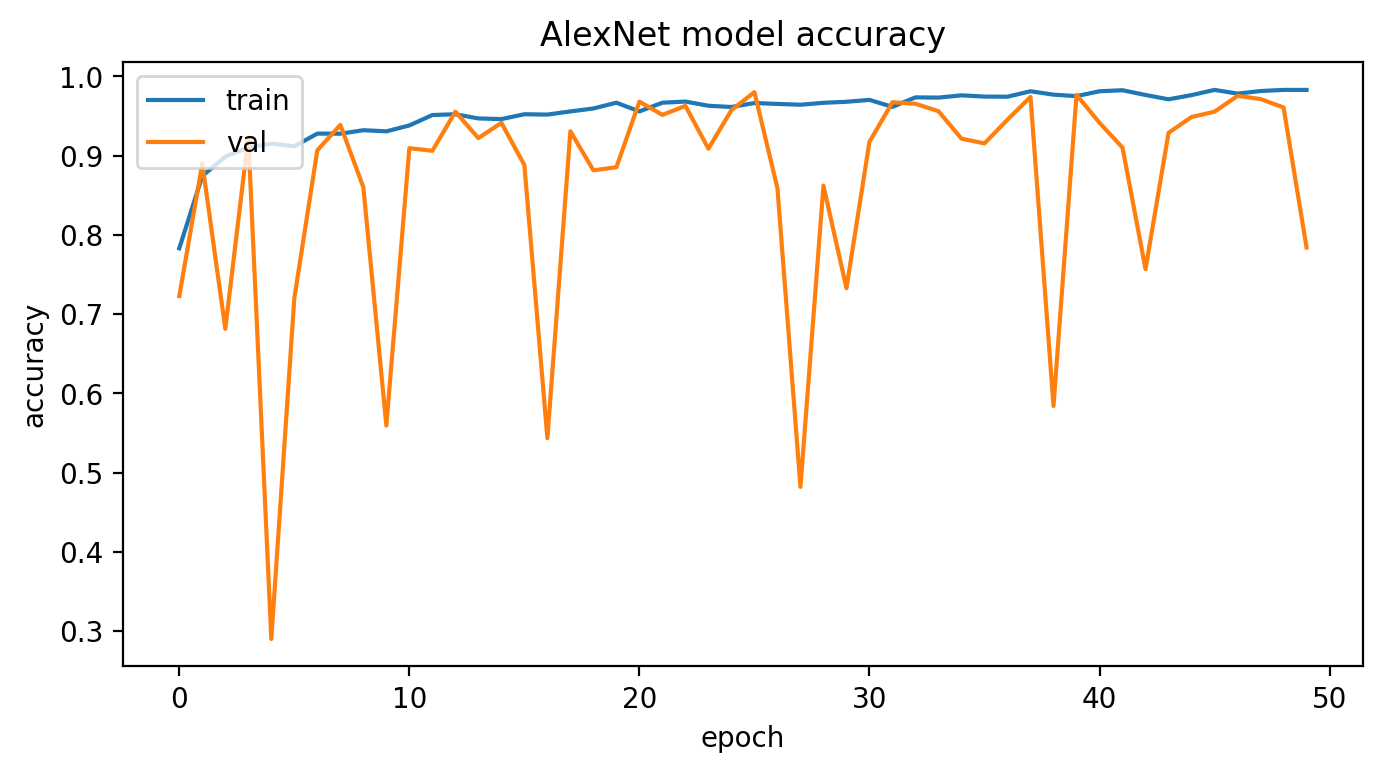

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(alex_history.history['accuracy'])
plt.plot(alex_history.history['val_accuracy'])
plt.title('AlexNet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

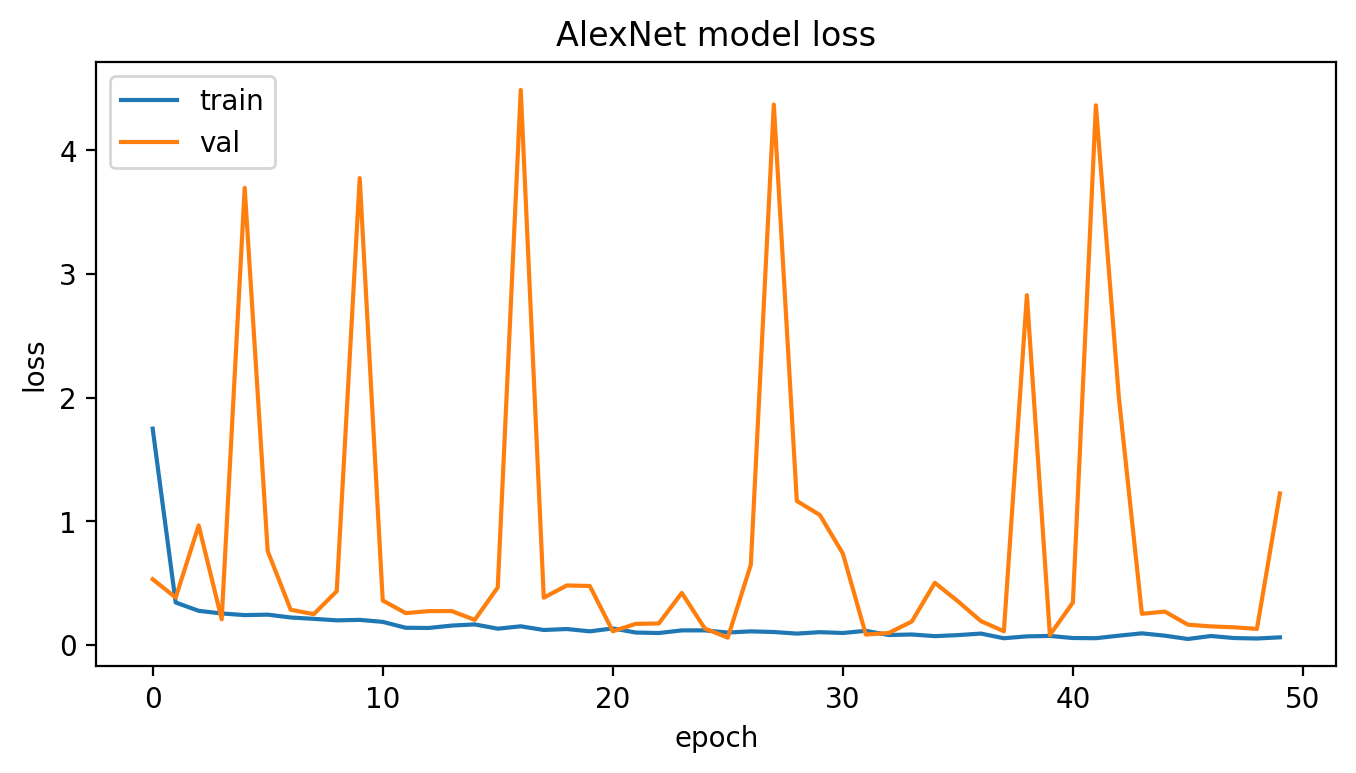

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(alex_history.history['loss'])
plt.plot(alex_history.history['val_loss'])
plt.title('AlexNet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
alex.save('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/alex.h5')

# GoogleNet

In [7]:
def googlenet(input_shape, n_classes):
  
  def inception_block(x, f):
    t1 = Conv2D(f[0], 1, activation='relu')(x)
    
    t2 = Conv2D(f[1], 1, activation='relu')(x)
    t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
    
    t3 = Conv2D(f[3], 1, activation='relu')(x)
    t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)
    
    t4 = MaxPool2D(3, 1, padding='same')(x)
    t4 = Conv2D(f[5], 1, activation='relu')(t4)
    
    output = Concatenate()([t1, t2, t3, t4])
    return output
  
  
  input = Input(input_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = Conv2D(64, 1, activation='relu')(x)
  x = Conv2D(192, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = inception_block(x, [64, 96, 128, 16, 32, 32])
  x = inception_block(x, [128, 128, 192, 32, 96, 64])
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = inception_block(x, [192, 96, 208, 16, 48, 64])
  x = inception_block(x, [160, 112, 224, 24, 64, 64])
  x = inception_block(x, [128, 128, 256, 24, 64, 64])
  x = inception_block(x, [112, 144, 288, 32, 64, 64])
  x = inception_block(x, [256, 160, 320, 32, 128, 128])
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = inception_block(x, [256, 160, 320, 32, 128, 128])
  x = inception_block(x, [384, 192, 384, 48, 128, 128])
  
  x = AvgPool2D(7, strides=1)(x)
  x = Dropout(0.4)(x)
  
  x = Flatten()(x)
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [8]:
input_shape = 224,224,3
n_classes = 2
google = googlenet(input_shape,n_classes)

In [9]:
google.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [10]:
g_history = google.fit(x= training_set, epochs= 50, validation_data= validation_set)

Epoch 1/50
376/376 [==============================] - 2299s 6s/step - loss: 0.2689 - accuracy: 0.8470 - val_loss: 0.0547 - val_accuracy: 0.9803
Epoch 2/50
376/376 [==============================] - 162s 430ms/step - loss: 0.0268 - accuracy: 0.9918 - val_loss: 0.0161 - val_accuracy: 0.9973
Epoch 3/50
376/376 [==============================] - 162s 430ms/step - loss: 0.0235 - accuracy: 0.9936 - val_loss: 0.0131 - val_accuracy: 0.9973
Epoch 4/50
376/376 [==============================] - 161s 429ms/step - loss: 0.0107 - accuracy: 0.9971 - val_loss: 0.0283 - val_accuracy: 0.9905
Epoch 5/50
376/376 [==============================] - 162s 431ms/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0333 - val_accuracy: 0.9880
Epoch 6/50
376/376 [==============================] - 161s 429ms/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.0118 - val_accuracy: 0.9962
Epoch 7/50
376/376 [==============================] - 161s 429ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0095 - v

In [11]:
google.save('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/50_epochs_ns/googlenet.h5')

In [12]:
path = "/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/images_ns/test/"

google_preds = []
for filename in os.listdir(path):
  new_path = path + filename + "/"
  for img in os.listdir(new_path):
    img_path = new_path + img
    test_image = image.load_img(img_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = google.predict(test_image)
    google_preds.append(np.argmax(result[0]))

In [13]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())
report = classification_report(true_classes, google_preds, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       cilek       1.00      0.07      0.13      3015
  cilekdegil       0.52      1.00      0.68      3020

    accuracy                           0.54      6035
   macro avg       0.76      0.54      0.41      6035
weighted avg       0.76      0.54      0.41      6035



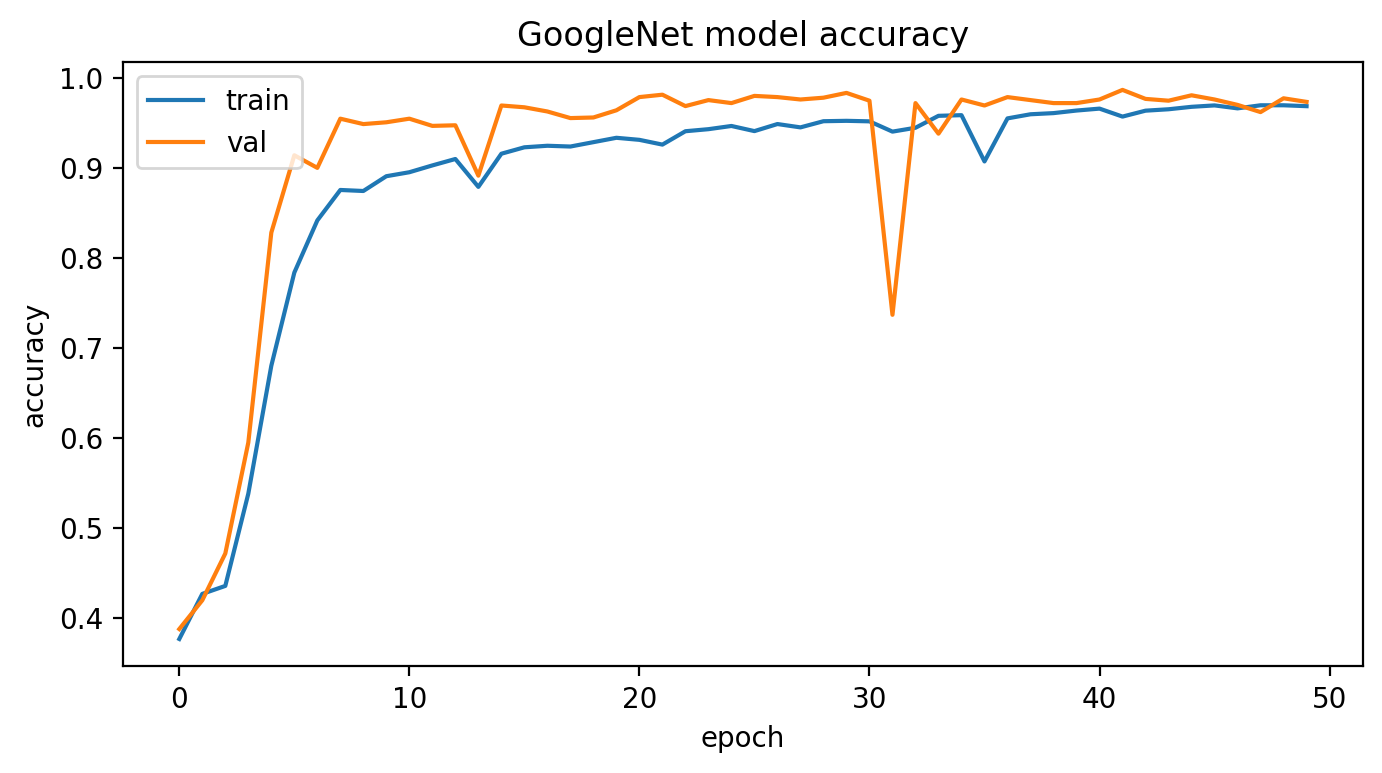

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(g_history.history['accuracy'])
plt.plot(g_history.history['val_accuracy'])
plt.title('GoogleNet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

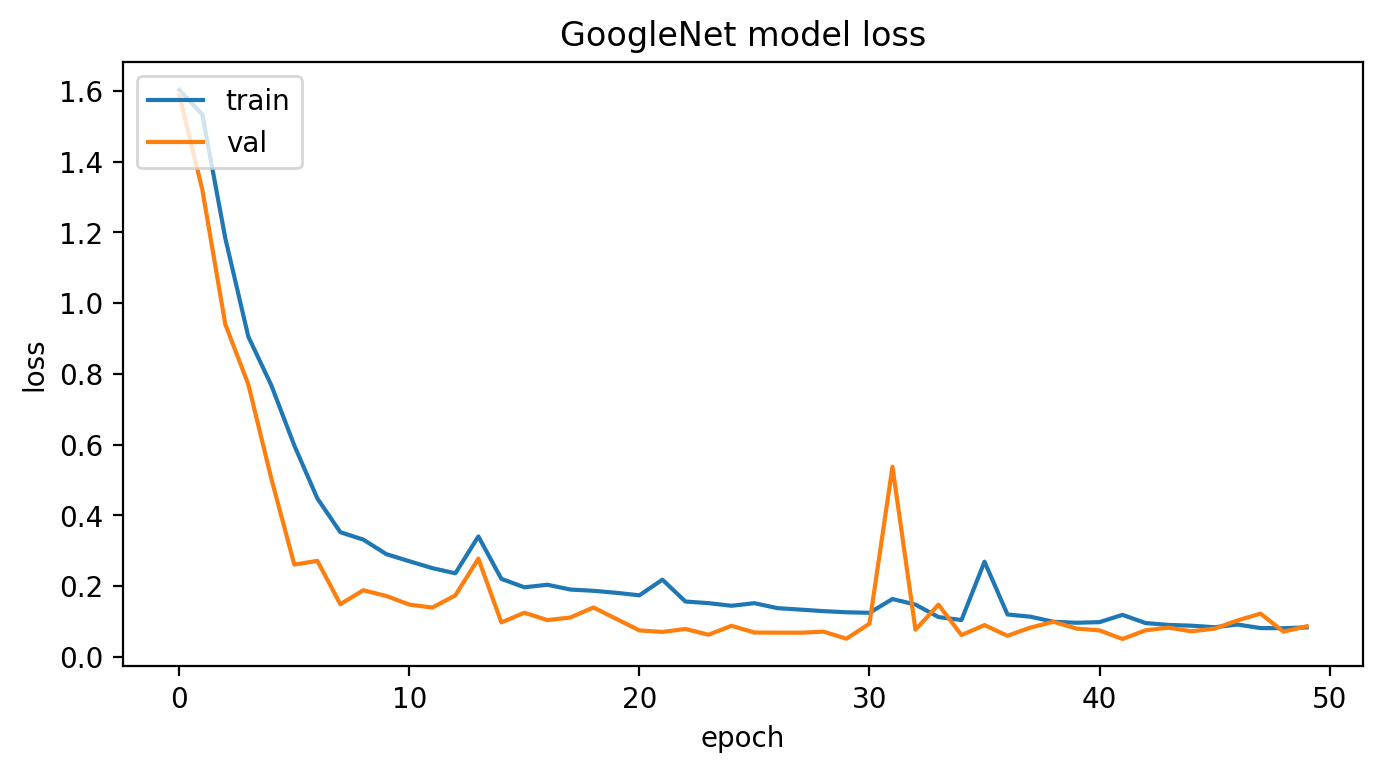

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(g_history.history['loss'])
plt.plot(g_history.history['val_loss'])
plt.title('GoogleNet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# XCeption

In [ ]:
def xception(input_shape, n_classes):
  
  def conv_bn(x, f, k, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x
  
  
  def sep_bn(x, f, k, s=1, p='same'):
    x = SeparableConv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x
  
  
  def entry_flow(x):
    x = conv_bn(x, 32, 3, 2)
    x = ReLU()(x)
    x = conv_bn(x, 64, 3)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, 128, 3)
    x = ReLU()(x)
    x = sep_bn(x, 128, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 128, 1, 2)
    
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 256, 1, 2)
    
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 728, 1, 2)
    x = Add()([tensor, x])
    
    return x
  
  
  def middle_flow(tensor):
    for _ in range(8):
      x = ReLU()(tensor)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)

      tensor = Add()([tensor, x])
    
    return tensor
  
  
  def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 1024, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 1024, 1, 2)
    
    x = Add()([tensor, x])
    x = sep_bn(x, 1536, 3)
    x = ReLU()(x)
    x = sep_bn(x, 2048, 3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(n_classes, activation='softmax')(x)
  
    return x
  
  
  input = Input(input_shape)
  
  x = entry_flow(input)
  x = middle_flow(x)
  output = exit_flow(x)
  
  model = Model(input, output)
  
  return model

In [ ]:
xcep = xception(input_shape,n_classes)
xcep.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
xcep_history = xcep.fit(x= training_set, epochs= 200, validation_data= validation_set)

Epoch 1/200
55/55 [==============================] - 34s 527ms/step - loss: 0.6496 - accuracy: 0.7846 - val_loss: 1.6086 - val_accuracy: 0.2000
Epoch 2/200
55/55 [==============================] - 28s 510ms/step - loss: 0.3349 - accuracy: 0.8869 - val_loss: 1.6053 - val_accuracy: 0.2000
Epoch 3/200
55/55 [==============================] - 28s 506ms/step - loss: 0.2514 - accuracy: 0.9051 - val_loss: 1.6020 - val_accuracy: 0.2000
Epoch 4/200
55/55 [==============================] - 28s 510ms/step - loss: 0.2940 - accuracy: 0.9017 - val_loss: 1.5784 - val_accuracy: 0.4000
Epoch 5/200
55/55 [==============================] - 28s 510ms/step - loss: 0.2003 - accuracy: 0.9274 - val_loss: 1.5486 - val_accuracy: 0.3947
Epoch 6/200
55/55 [==============================] - 28s 507ms/step - loss: 0.2066 - accuracy: 0.9217 - val_loss: 1.4466 - val_accuracy: 0.4000
Epoch 7/200
55/55 [==============================] - 28s 509ms/step - loss: 0.1889 - accuracy: 0.9320 - val_loss: 1.1616 - val_accuracy:

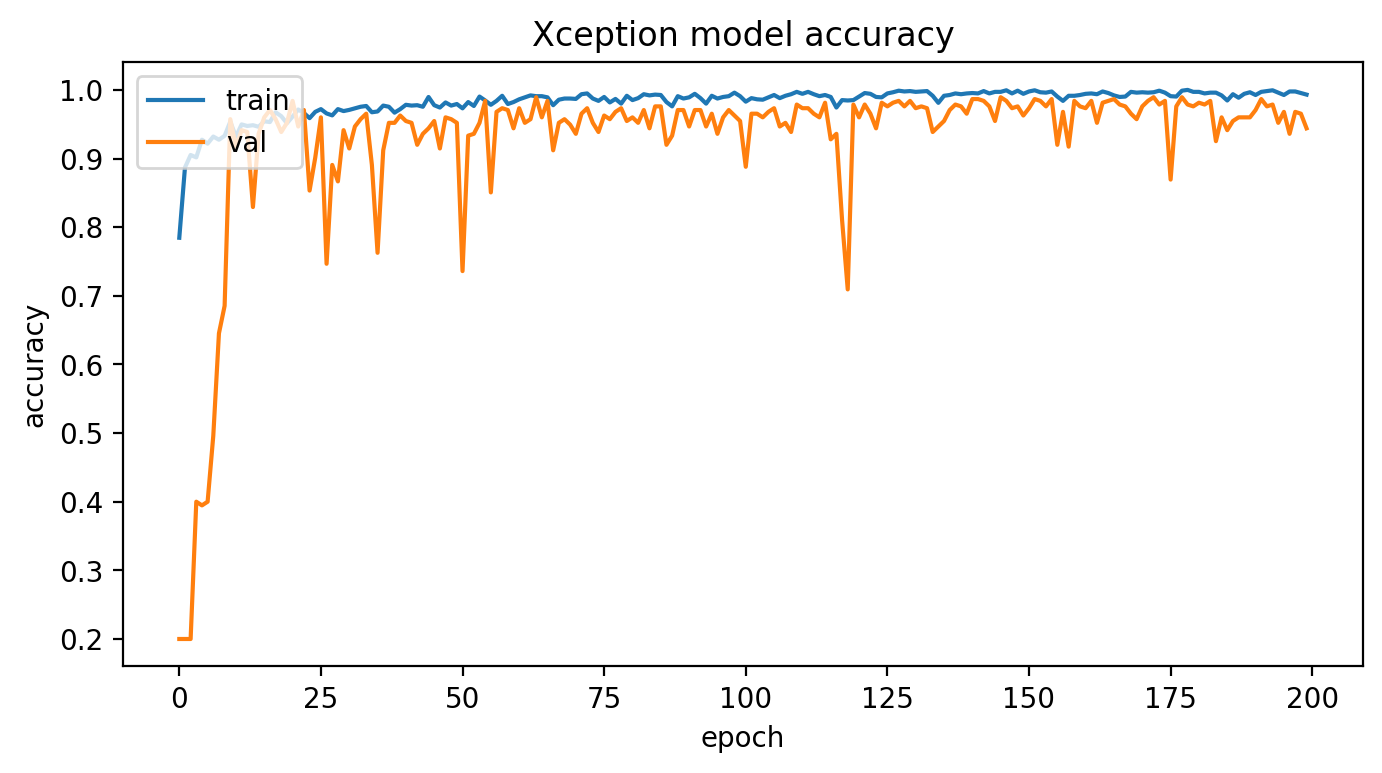

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(xcep_history.history['accuracy'])
plt.plot(xcep_history.history['val_accuracy'])
plt.title('Xception model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

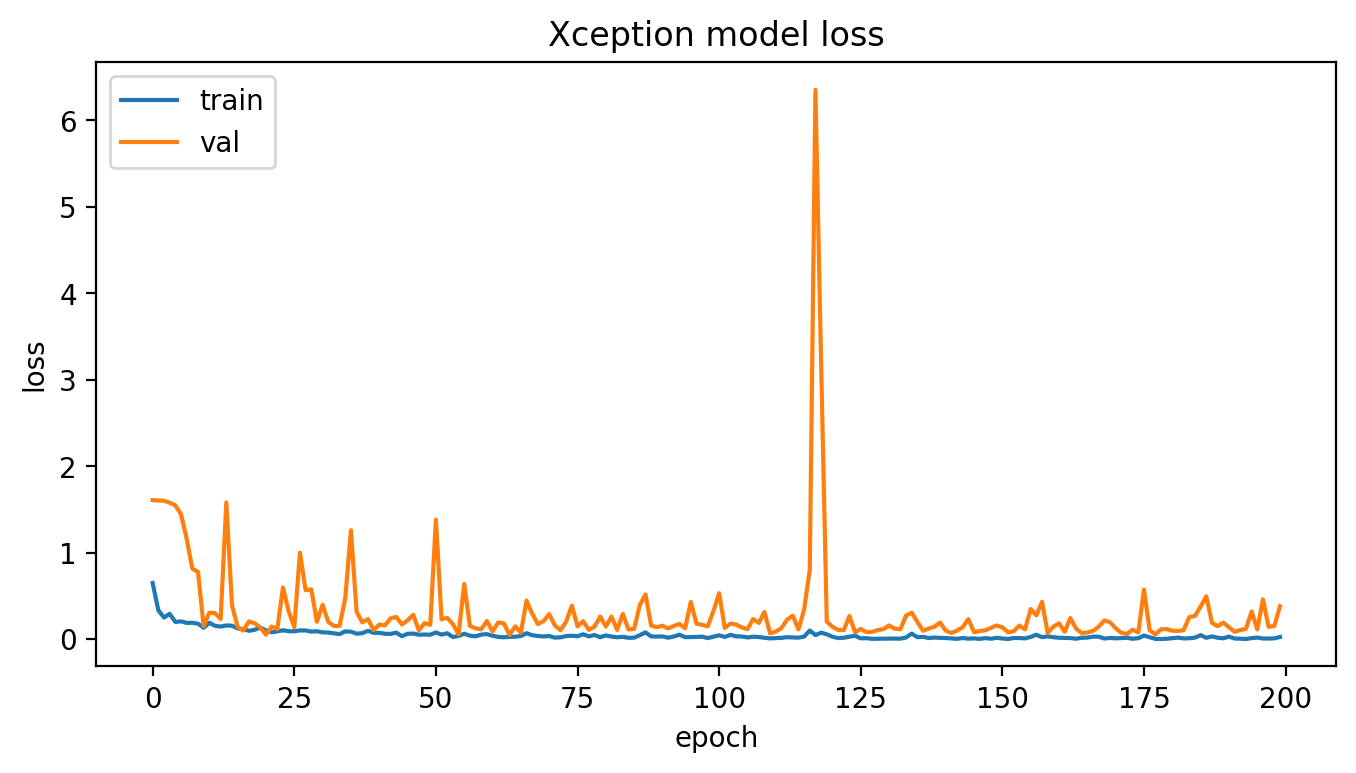

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(xcep_history.history['loss'])
plt.plot(xcep_history.history['val_loss'])
plt.title('Xception model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
path = "/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/images2/test/"

xcep_preds = []
for filename in os.listdir(path):
  new_path = path + filename + "/"
  for img in os.listdir(new_path):
    img_path = new_path + img
    test_image = image.load_img(img_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image /= 255. 
    result = xcep.predict(test_image)
    xcep_preds.append(np.argmax(result[0]))

In [ ]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())
report = classification_report(true_classes, xcep_preds, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

 cilekcicegi       0.02      0.02      0.02       125
       curuk       0.00      0.00      0.00       125
       olgun       0.97      0.89      0.93       125
     olmamis       0.00      0.00      0.00       125
   yariolgun       0.00      0.00      0.00       125

    accuracy                           0.18       625
   macro avg       0.20      0.18      0.19       625
weighted avg       0.20      0.18      0.19       625



In [ ]:
xcep.save('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/xception.h5')

# DenseNet

In [ ]:
def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [ ]:
dense = densenet(input_shape,n_classes)
dense.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
dense_history = dense.fit(x= training_set, epochs= 200, validation_data= validation_set)

Epoch 1/200
55/55 [==============================] - 749s 13s/step - loss: 1.0995 - accuracy: 0.7211 - val_loss: 9.3160 - val_accuracy: 0.3147
Epoch 2/200
55/55 [==============================] - 28s 502ms/step - loss: 0.5057 - accuracy: 0.8577 - val_loss: 7.1809 - val_accuracy: 0.4427
Epoch 3/200
55/55 [==============================] - 28s 500ms/step - loss: 0.4877 - accuracy: 0.8674 - val_loss: 7.0936 - val_accuracy: 0.6373
Epoch 4/200
55/55 [==============================] - 28s 498ms/step - loss: 0.4215 - accuracy: 0.8703 - val_loss: 1.7395 - val_accuracy: 0.7467
Epoch 5/200
55/55 [==============================] - 27s 491ms/step - loss: 0.3007 - accuracy: 0.9040 - val_loss: 2.9063 - val_accuracy: 0.6507
Epoch 6/200
55/55 [==============================] - 27s 492ms/step - loss: 0.2619 - accuracy: 0.9149 - val_loss: 3.1510 - val_accuracy: 0.6480
Epoch 7/200
55/55 [==============================] - 27s 492ms/step - loss: 0.4109 - accuracy: 0.8857 - val_loss: 3.6071 - val_accuracy: 

In [ ]:
path = "/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/images2/test/"

dense_preds = []
for filename in os.listdir(path):
  new_path = path + filename + "/"
  for img in os.listdir(new_path):
    img_path = new_path + img
    test_image = image.load_img(img_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image /= 255.
    result = dense.predict(test_image)
    dense_preds.append(np.argmax(result[0]))

In [ ]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())
report = classification_report(true_classes, dense_preds, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

 cilekcicegi       0.00      0.00      0.00       125
       curuk       0.00      0.00      0.00       125
       olgun       0.92      0.97      0.95       125
     olmamis       0.04      0.04      0.04       125
   yariolgun       0.00      0.00      0.00       125

    accuracy                           0.20       625
   macro avg       0.19      0.20      0.20       625
weighted avg       0.19      0.20      0.20       625



In [ ]:
dense.save('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/densenet.h5')

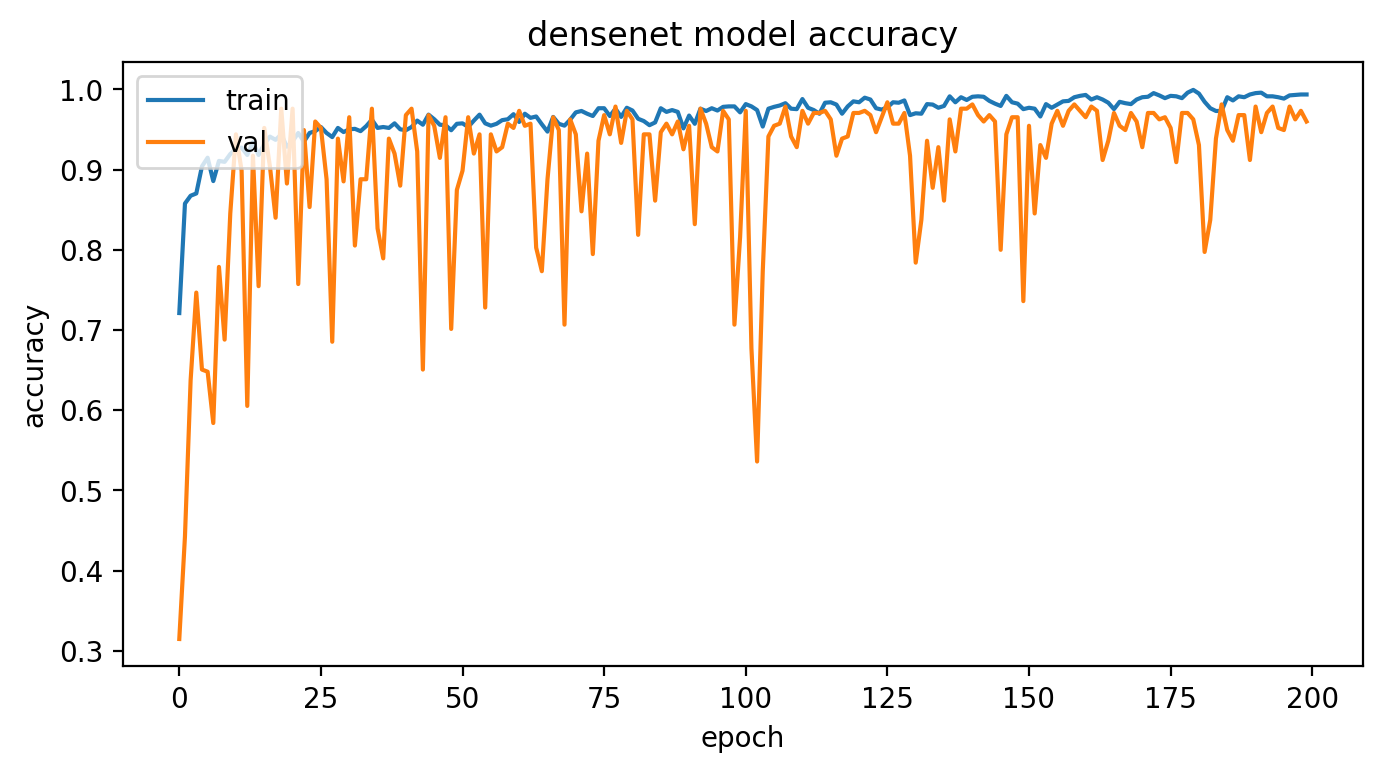

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(dense_history.history['accuracy'])
plt.plot(dense_history.history['val_accuracy'])
plt.title('densenet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

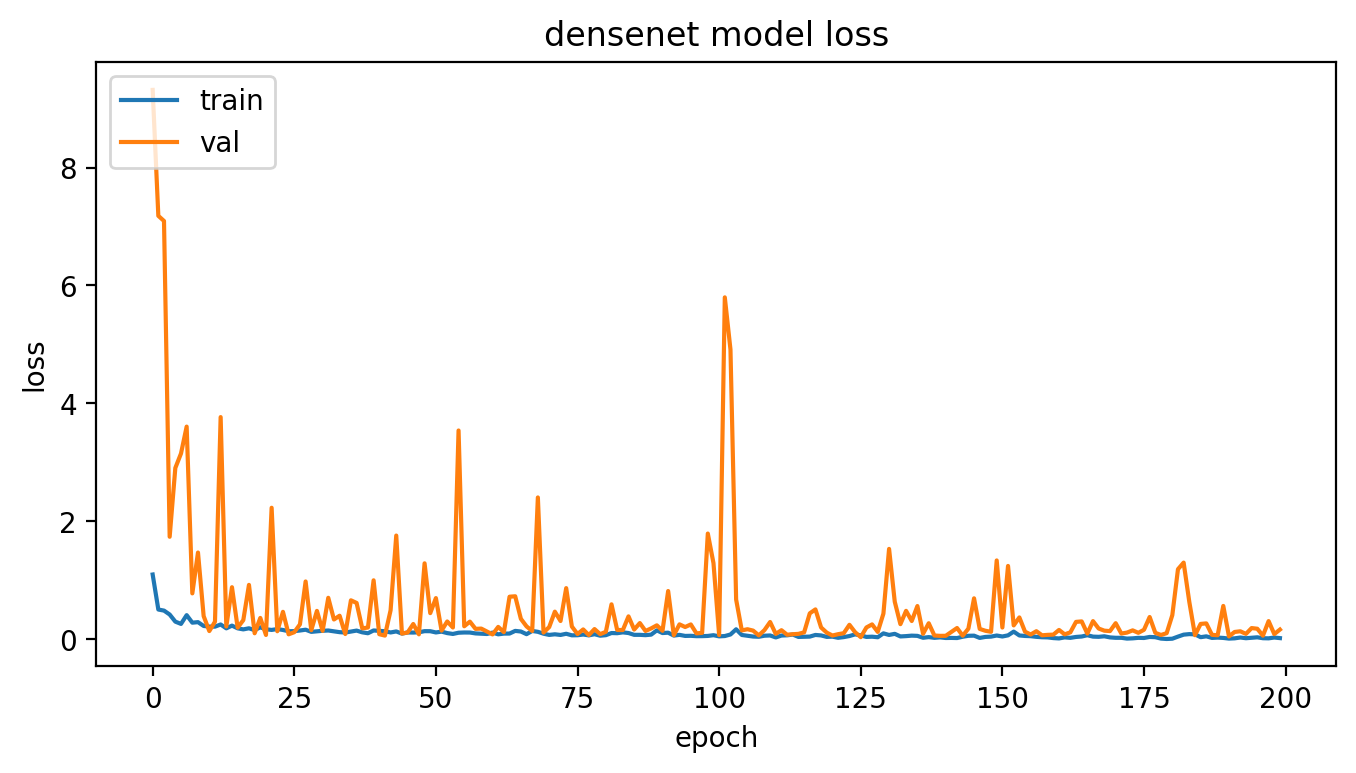

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(dense_history.history['loss'])
plt.plot(dense_history.history['val_loss'])
plt.title('densenet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False  

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

x = layers.Flatten()(pre_trained_model.output)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.2)(x)                  

x = layers.Dense(5, activation='softmax')(x)           

iv3 = Model( pre_trained_model.input, x) 

iv3.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [ ]:
iv3_history = iv3.fit(x= training_set, epochs= 200, validation_data= validation_set)

Epoch 1/200
55/55 [==============================] - 34s 514ms/step - loss: 17.3200 - accuracy: 0.6960 - val_loss: 0.4697 - val_accuracy: 0.9200
Epoch 2/200
55/55 [==============================] - 27s 482ms/step - loss: 0.6867 - accuracy: 0.8794 - val_loss: 0.4929 - val_accuracy: 0.8880
Epoch 3/200
55/55 [==============================] - 26s 481ms/step - loss: 0.3262 - accuracy: 0.8989 - val_loss: 0.2282 - val_accuracy: 0.9147
Epoch 4/200
55/55 [==============================] - 27s 489ms/step - loss: 0.2626 - accuracy: 0.9086 - val_loss: 0.2838 - val_accuracy: 0.9120
Epoch 5/200
55/55 [==============================] - 27s 482ms/step - loss: 0.2417 - accuracy: 0.9171 - val_loss: 0.1805 - val_accuracy: 0.9307
Epoch 6/200
55/55 [==============================] - 26s 482ms/step - loss: 0.2317 - accuracy: 0.9166 - val_loss: 0.2358 - val_accuracy: 0.9200
Epoch 7/200
55/55 [==============================] - 27s 484ms/step - loss: 0.2139 - accuracy: 0.9143 - val_loss: 0.2705 - val_accuracy

In [ ]:
path = "/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/images2/test/"

iv3_preds = []
for filename in os.listdir(path):
  new_path = path + filename + "/"
  for img in os.listdir(new_path):
    img_path = new_path + img
    test_image = image.load_img(img_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image /= 255.
    result = iv3.predict(test_image)
    iv3_preds.append(np.argmax(result[0]))

In [ ]:
from sklearn.metrics import classification_report
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

report = classification_report(true_classes, iv3_preds, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

 cilekcicegi       0.03      0.03      0.03       125
       curuk       0.00      0.00      0.00       125
       olgun       0.92      0.96      0.94       125
     olmamis       0.00      0.00      0.00       125
   yariolgun       0.00      0.00      0.00       125

    accuracy                           0.20       625
   macro avg       0.19      0.20      0.19       625
weighted avg       0.19      0.20      0.19       625



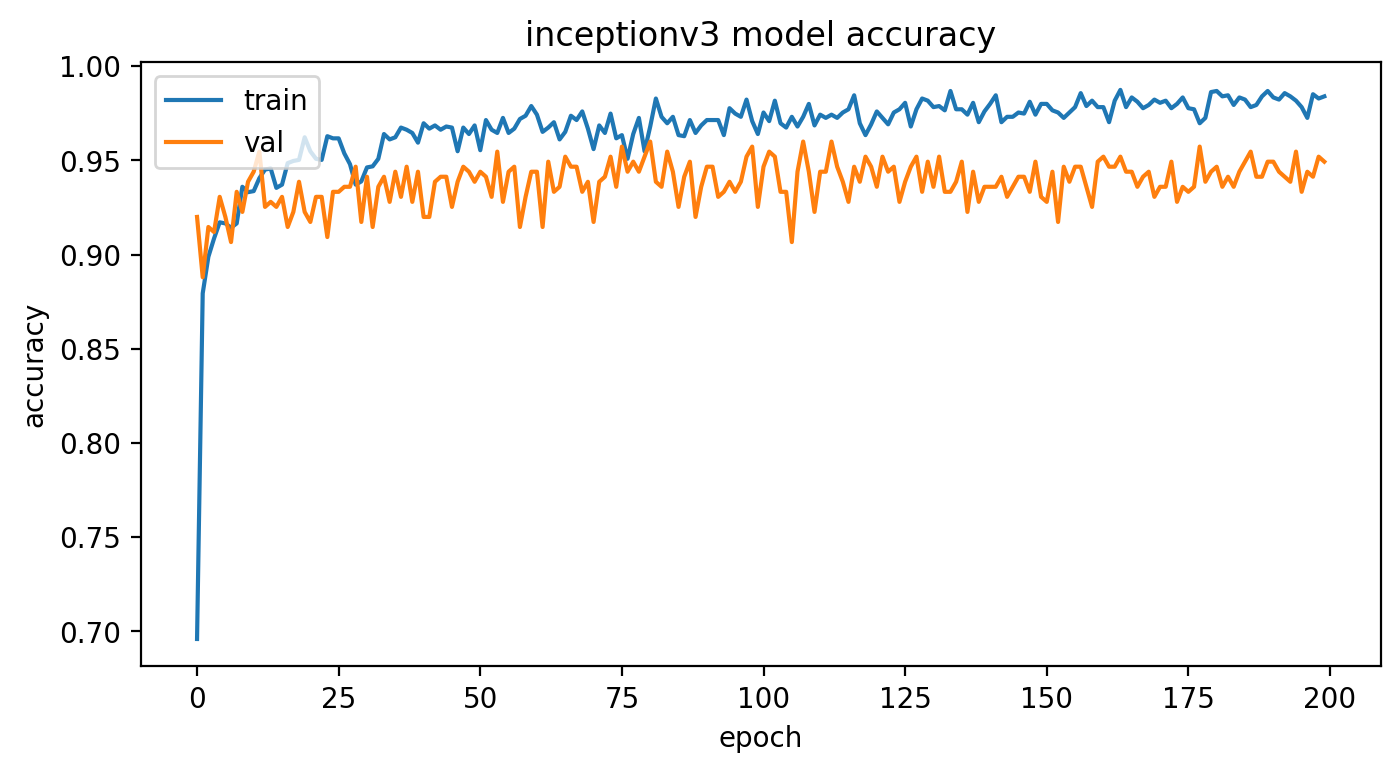

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(iv3_history.history['accuracy'])
plt.plot(iv3_history.history['val_accuracy'])
plt.title('inceptionv3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

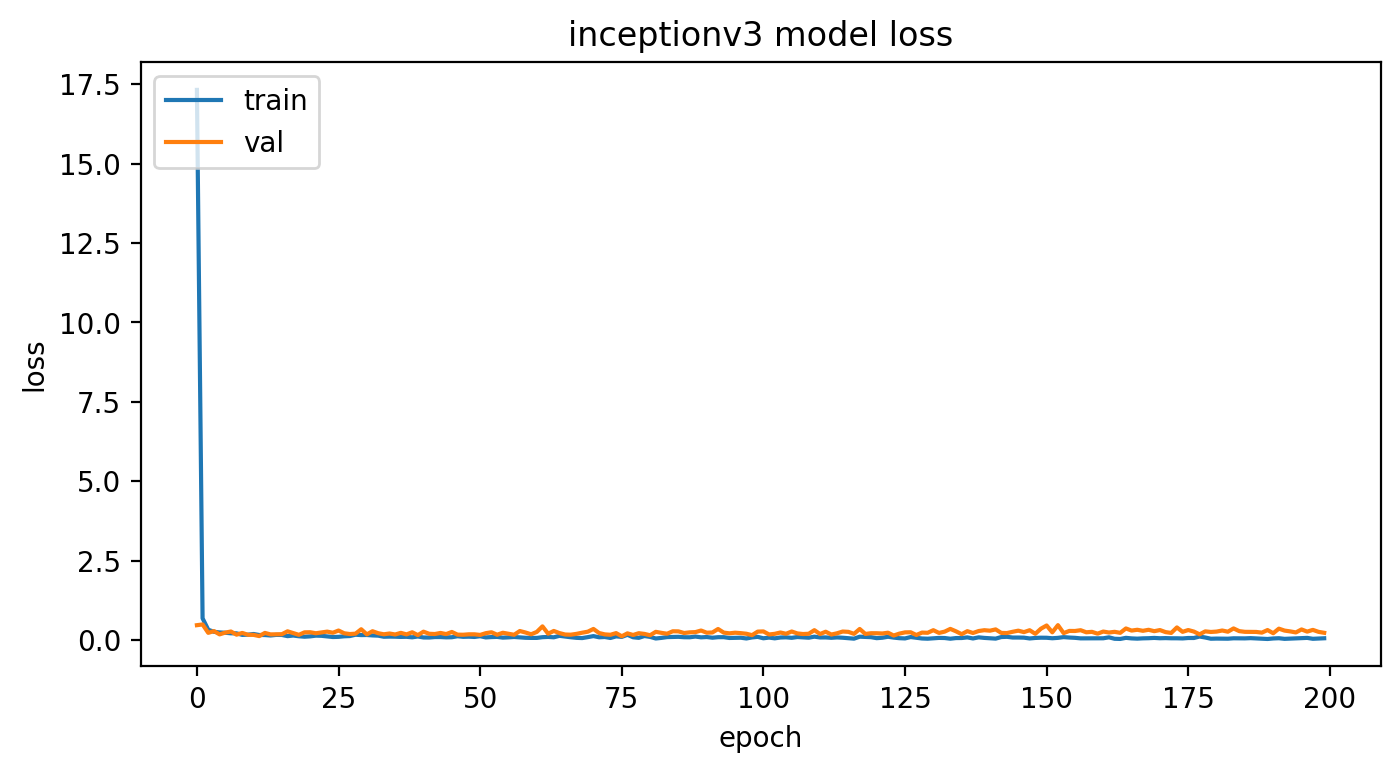

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(iv3_history.history['loss'])
plt.plot(iv3_history.history['val_loss'])
plt.title('inceptionv3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
iv3.save('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/iv3.h5')

# VGG19

In [ ]:
vgg = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
prediction = Dense(5, activation='softmax')(x)

vgg19 = Model(inputs=vgg.input, outputs=prediction)

vgg19.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg_history = vgg19.fit(x=training_set, epochs= 200, validation_data=validation_set)





80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/200
55/55 [==============================] - 734s 13s/step - loss: 0.9080 - accuracy: 0.6977 - val_loss: 0.2965 - val_accuracy: 0.8960
Epoch 2/200
55/55 [==============================] - 23s 418ms/step - loss: 0.2617 - accuracy: 0.8989 - val_loss: 0.2282 - val_accuracy: 0.9173
Epoch 3/200
55/55 [==============================] - 23s 415ms/step - loss: 0.1998 - accuracy: 0.9297 - val_loss: 0.2421 - val_accuracy: 0.9040
Epoch 4/200
55/55 [==============================] - 23s 417ms/step - loss: 0.1773 - accuracy: 0.9297 - val_loss: 0.1627 - val_accuracy: 0.9413
Epoch 5/200
55/55 [==============================] - 23s 417ms/step - loss: 0.1743 - accuracy: 0.9349 - val_loss: 0.1986 - val_accuracy: 0.9360
Epoch 6/200
55/55 [==============================] - 23s 415ms/step - loss: 0.1311 - accuracy: 0.9606 - val_loss: 0.1915 - val_accuracy: 0.9307
Epoch 7/200
55/55 [==============================] - 23s 418ms/step - lo

In [ ]:
path = "/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/images2/test/"

vgg19_preds = []
for filename in os.listdir(path):
    new_path = path + filename + "/"
    for img in os.listdir(new_path):
        img_path = new_path + img
        test_image = image.load_img(img_path, target_size=(224, 224))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)
        test_image /= 255.
        result = vgg19.predict(test_image)
        vgg19_preds.append(np.argmax(result[0]))

true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())
report = classification_report(true_classes, vgg19_preds, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

 cilekcicegi       0.04      0.04      0.04       125
       curuk       0.01      0.01      0.01       125
       olgun       0.87      0.98      0.92       125
     olmamis       0.00      0.00      0.00       125
   yariolgun       0.00      0.00      0.00       125

    accuracy                           0.21       625
   macro avg       0.18      0.21      0.19       625
weighted avg       0.18      0.21      0.19       625



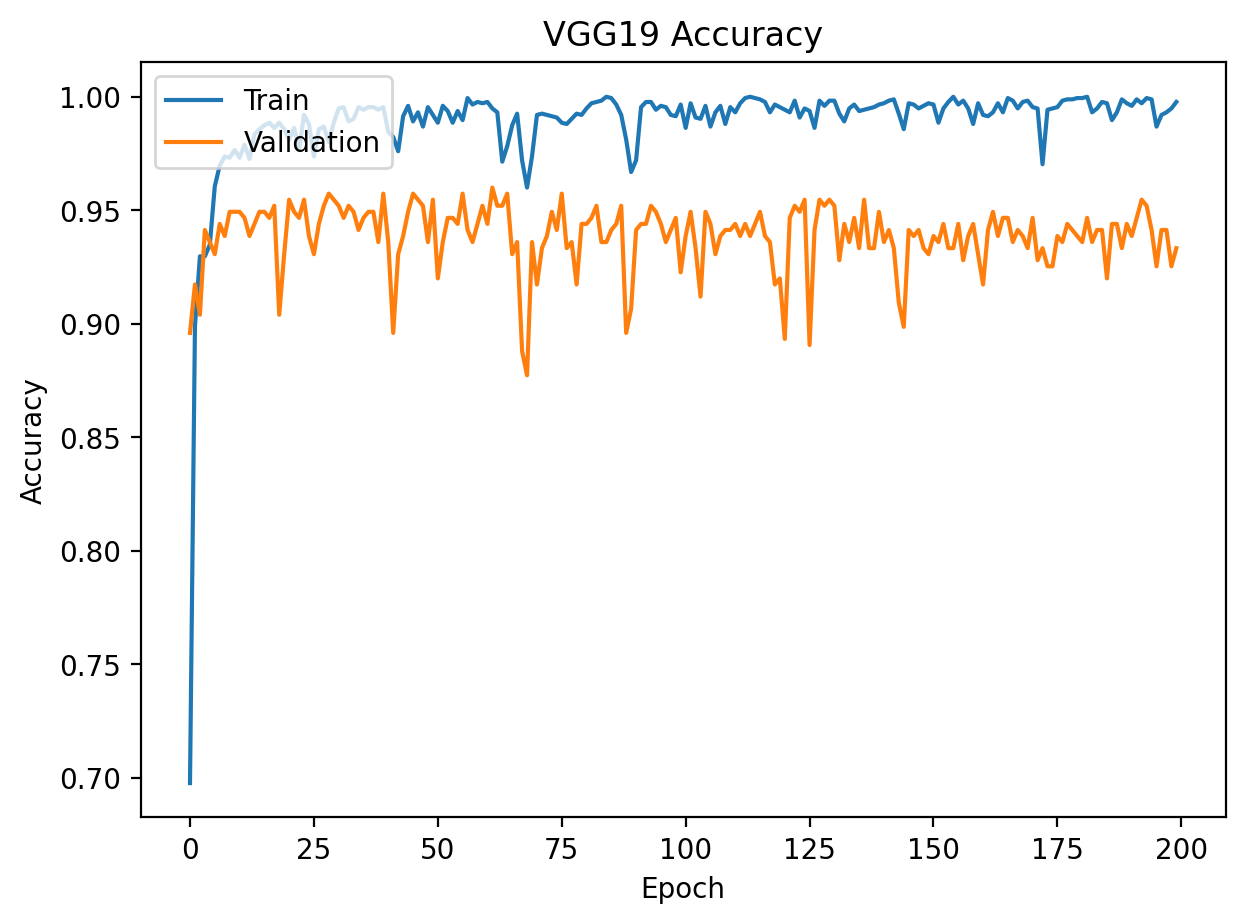

In [ ]:
plt.figure(figsize=(7, 5), dpi=200)
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('VGG19 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

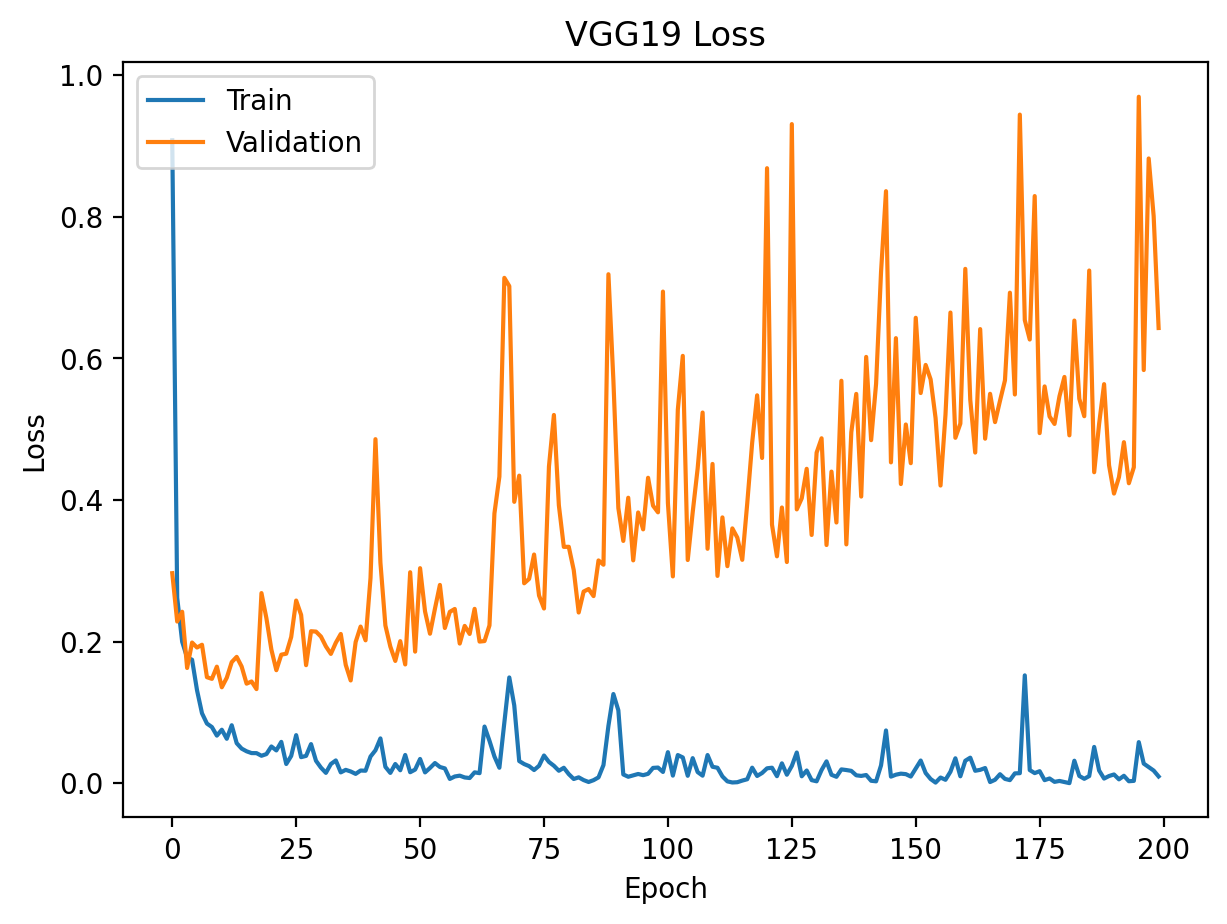

In [ ]:
plt.figure(figsize=(7, 5), dpi=200)
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('VGG19 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
vgg19.save('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/vgg19.h5')